# Importation et préparation des données

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv("sales_data.csv")

#Vérification et nettoyage des données

print(df.info())
print(df.isnull().sum())
print(df.duplicated().sum())

# Sélectionner un produit (ex. : P0001)
product_df = df[df["Product ID"] == "P0001"]

# Colonnes utiles
product_df = product_df[["Date", "Inventory Level", "Units Sold", "Price"]]
product_df = product_df.sort_values(by="Date")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null  int64  
dtypes: f

# Définition des états et actions

In [3]:
# États = niveaux de stock discrétisés
stock_bins = list(range(0, 251, 25))  # 0, 25, ..., 250
n_states = len(stock_bins)

# Actions = niveaux de prix fixés
price_actions = [60, 70, 80]
n_actions = len(price_actions)

# Initialiser la Q-table
Q = np.zeros((n_states, n_actions))

# Paramètres Q-learning
alpha = 0.1      # learning rate
gamma = 0.9      # discount factor
epsilon = 0.2    # exploration

# Fonction de simulation des ventes

In [4]:
def simulate_sales(price, stock):
    """
    Simule les unités vendues selon le prix.
    Plus le prix est bas, plus la demande est forte.
    """
    if price == 60:
        return min(stock, np.random.randint(18, 25))
    elif price == 70:
        return min(stock, np.random.randint(10, 18))
    elif price == 80:
        return min(stock, np.random.randint(2, 10))
    return 0

# Entraînement de l’agent Q-learning

In [5]:
episodes = 1000
rewards_per_episode = []

for ep in range(episodes):
    stock = 200  # Stock initial
    total_reward = 0

    while stock > 0:
        state_idx = min(len(stock_bins)-1, stock // 25)

        # Choisir une action (ε-greedy)
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(0, n_actions)
        else:
            action_idx = np.argmax(Q[state_idx])

        price = price_actions[action_idx]

        # Simuler les ventes
        sales = simulate_sales(price, stock)
        reward = sales * price
        total_reward += reward

        # Mise à jour du stock
        new_stock = stock - sales
        next_state_idx = min(len(stock_bins)-1, new_stock // 25)

        # Q-learning update
        Q[state_idx, action_idx] += alpha * (
            reward + gamma * np.max(Q[next_state_idx]) - Q[state_idx, action_idx]
        )

        stock = new_stock

    rewards_per_episode.append(total_reward)

    if ep % 100 == 0:
        print(f"Épisode {ep} - Revenu total : {total_reward:.2f}")

Épisode 0 - Revenu total : 12180.00
Épisode 100 - Revenu total : 12170.00
Épisode 200 - Revenu total : 12170.00
Épisode 300 - Revenu total : 12170.00
Épisode 400 - Revenu total : 12170.00
Épisode 500 - Revenu total : 12000.00
Épisode 600 - Revenu total : 12110.00
Épisode 700 - Revenu total : 12240.00
Épisode 800 - Revenu total : 12620.00
Épisode 900 - Revenu total : 12310.00


# Visualisation des résultats

Politique apprise (prix recommandé par niveau de stock) :
Stock 0: Prix recommandé = 60€
Stock 25: Prix recommandé = 60€
Stock 50: Prix recommandé = 60€
Stock 75: Prix recommandé = 60€
Stock 100: Prix recommandé = 60€
Stock 125: Prix recommandé = 60€
Stock 150: Prix recommandé = 60€
Stock 175: Prix recommandé = 60€
Stock 200: Prix recommandé = 60€
Stock 225: Prix recommandé = 60€
Stock 250: Prix recommandé = 60€


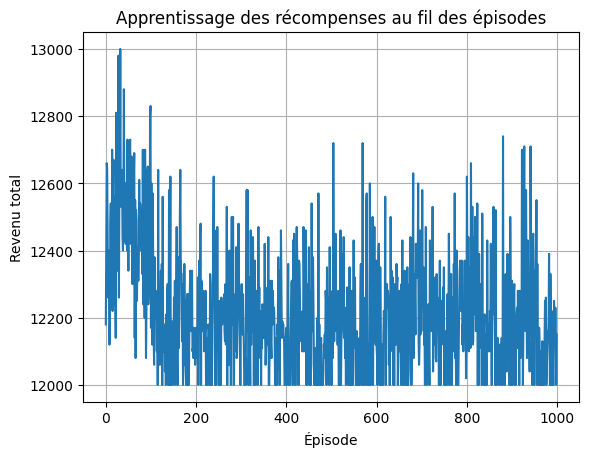

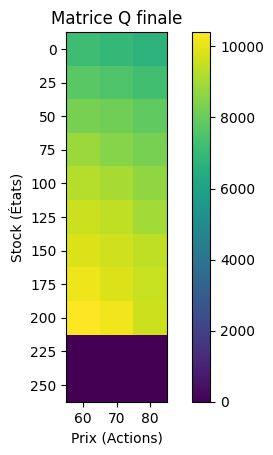

In [6]:
# Politique finale
print("Politique apprise (prix recommandé par niveau de stock) :")
for i, s in enumerate(stock_bins):
    best_action = np.argmax(Q[i])
    print(f"Stock {s}: Prix recommandé = {price_actions[best_action]}€")

# Courbe des récompenses
plt.plot(rewards_per_episode)
plt.xlabel("Épisode")
plt.ylabel("Revenu total")
plt.title("Apprentissage des récompenses au fil des épisodes")
plt.grid()
plt.show()

# Heatmap de la Q-table
plt.imshow(Q, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=range(n_actions), labels=price_actions)
plt.yticks(ticks=range(n_states), labels=stock_bins)
plt.xlabel("Prix (Actions)")
plt.ylabel("Stock (États)")
plt.title("Matrice Q finale")
plt.show()